In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy
from scipy.stats import linregress
import matplotlib
import bluepysnap as bp

In [2]:
%matplotlib widget

In [3]:
# Defines paths to the two simulation campaigns
s = 'c6c46053-7bd4-475d-8919-b3ac90585eea/'
s1 = '/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/original/fixed/a9f782a3-1f22-4384-a122-430bc6b2323c'
s2 = '/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/rewired/f090d92c-29b1-4033-96d2-e1a67b33dab6'
s3 = '/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/disconnected/fixed/ecb3ceed-f1bf-4ff0-8067-9bcfd0d2bf4f'
s4 = '/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/rewired/reduceInhibition/L23_BTC/da48f665-8b07-4aaf-a8f2-7a4c52f9df71'
s5 = '/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/rewired/reduceInhibition/L5_BTC/ebc8e94d-37ea-4bad-af06-32defff79dbb'
s6 = '/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/rewired/disconnected/af883cc4-40c0-4a0e-a179-a329c87fb346'
s7 = '/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/rewired/disconnected/silent/69470182-2140-4078-9a09-6d7fe0d798e0'


In [4]:
def getHistByLayer(path_to_sims,bins=None):

    '''
    Thsi function iterates through all of the trials, and produces a spike time histogram for each layer, separately for excitatory and inhibitory cells. 
    Outputs a matrix of size nTrials x 2 x nLayers x nBins
    '''

    numSims = 1
    numLayers = 6
    numBins = 225
    bins = np.linspace(1975,2200,numBins+1)

    allSpikes = np.zeros([numSims,2,numLayers,numBins])
   
    for sim in range(numSims):

        s = bp.Simulation( path_to_sims + '/'+str(sim)+'/simulation_config.json' )

        c = s.circuit
        layerDF = list(c.nodes.get(group='hex_O1',properties=['layer','synapse_class']))[0][1].loc['S1nonbarrel_neurons']
    
        for layer in np.arange(1,numLayers+1):

            layerIds = list(layerDF[layerDF['layer']==layer].index)


            for classIdx, synClass in enumerate(['EXC','INH']):

                classIds = list(layerDF[layerDF['synapse_class']==synClass].index)

                selectedIds = np.intersect1d(layerIds,classIds)

            
                spikes = s.spikes['S1nonbarrel_neurons'].get(group=selectedIds,t_start=1975,t_stop=2200)

            
                if bins is None:
                    
                    spike_hist,bins = np.histogram(list(spikes.index),bins=numBins)

    
                else:
    
                    spike_hist,_ = np.histogram(list(spikes.index),bins=bins)
            
                allSpikes[sim,classIdx,layer-1] = spike_hist


    return allSpikes, bins

In [7]:
spikes_original, bins = getHistByLayer(s)

In [8]:
bins = (bins[:-1]+bins[1:])/2

In [5]:
def meanAndCI(EEGs):

    '''
    Given a matrix of EEG or spike histograms for each trial, finds the mean and 95% CI over trials
    '''

    mean = np.mean(EEGs,axis=0)

    lowerbound = scipy.stats.t.ppf(0.05,9,mean,np.std(EEGs,axis=0))
    upperbound = scipy.stats.t.ppf(0.95,9,mean,np.std(EEGs,axis=0))

    return mean, lowerbound, upperbound

In [6]:
def getEEGsByTypes(path):

    '''
    Given a path ot a simulation, creates a dictionary of EEG signals for each cell type
    '''

    EEGs = {}

    for file in os.listdir(path+'/pkls'):
        t = file.split('.')[0].split('g')[1]
        
        EEGs[t] = pd.read_pickle(path+'/pkls/'+file).values[19750:22000,0] # For memory reasons, we extract only a portion of the signal

    return EEGs

In [7]:
def getEEGByLayer(path_to_sims):

    '''
    Iterates over all trials, and produces a matrix of the EEG contributions of each layer, for excitatory and inhibitory cells separately
    Outputs a matrix of size nTrials x 2 x nLayers x nTimeSteps
    '''

    duration = 22000-19750

    allEEGList = []

    for sim in range(10):

        s = bp.Simulation( path_to_sims +'/'+str(sim) + '/simulation_config.json' )
        c = s.circuit
        
    
        eegEXC = np.zeros((7,duration))
        eegINH = np.zeros((7,duration))
    
        eegList = [eegEXC, eegINH]

        EEGsByTypes = getEEGsByTypes(path_to_sims +'/'+str(sim))
    
        for mtype in np.sort(np.unique(list(EEGsByTypes.keys()))):
    
            synsDF = list(c.nodes.get(group=mtype,properties=['synapse_class']))[0][1].loc['S1nonbarrel_neurons'].iloc[0].values
    
            if synsDF=='EXC':
                synIdx = 0
            elif synsDF=='INH':
                synIdx = 1
    
            layer = int(mtype.split('_')[0].split('L')[1])
    
            if layer == 2 or layer == 3 or layer == 23:
                layer = 2
    
            eegList[synIdx][layer] += (EEGsByTypes[mtype]-np.mean(EEGsByTypes[mtype][:250])) # Removes baseline offset

            allEEGList.append(eegList)                          
    
    
    return np.array(allEEGList)

In [8]:
def getEEGs(path):

    '''
    Given a path to simulations, outputs the EEG from each trial
    Outputs a matrix of size nTrials x nTimeSteps
    '''

    EEGs = list(np.zeros(10))

    for i in range(10):

        for file in os.listdir(path+'/'+str(i)+'/pkls'):

            EEGs[i] += pd.read_pickle(path+'/'+str(i)+'/pkls/'+file).values[19750:22000,0] # For memory reasons, we extract only a portion of the signal

    
    EEGs = np.array(EEGs)
    EEGs -= np.mean(EEGs[:,:250],axis=-1)[:,np.newaxis] # Removes baseline offset

    return EEGs

In [9]:
def getStuff(path):

    EEGs = getEEGs(path)
    mean, lowerbound, upperbound = meanAndCI(EEGs)

    return mean, lowerbound, upperbound

In [10]:
def getByLayer(path):

    EEGs = np.array(getEEGByLayer(path))
    mean, lowerbound, upperbound = meanAndCI(EEGs)

    return mean, lowerbound, upperbound 

In [9]:
meanEEG, lowerboundEEG, upperboundEEG = getStuff(s)

NameError: name 'np' is not defined

In [11]:
mean_layer, lowerbound_layer, upperbound_layer = getByLayer(s)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [32]:
mean_layer[0][3]

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
mean_layer_rewired.shape

(2, 7, 2250)

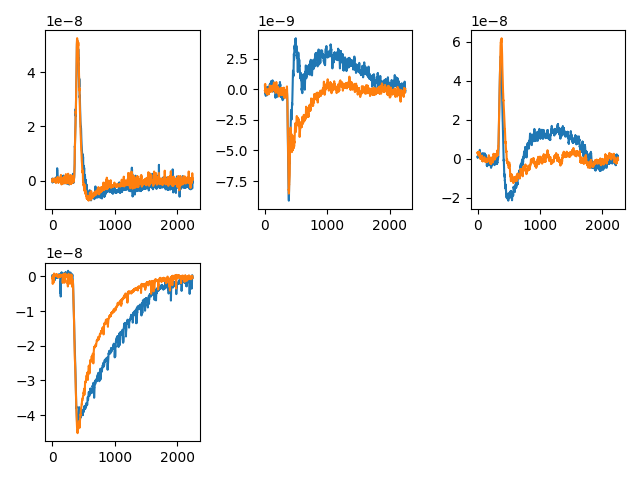

In [20]:
plt.figure()
layers = [2,4,5,6]
for i, layer in enumerate(layers):
    plt.subplot(2,3,i+1)
    plt.plot(np.sum(mean_layer_original[:,layer,:],axis=0))
    # plt.plot(mean_layer_rewired[0,layer,:])
    plt.plot(np.sum(mean_layer_disconnected[:,layer,:],axis=0))
    # plt.plot(mean_layer_rewiredD[0,layer,:])
    # plt.plot(mean_layer_rewiredDS[0,layer,:])
    # plt.plot(mean_layer_L23[0,layer,:])
    # plt.plot(mean_layer_L5[0,layer,:])
plt.tight_layout()
plt.show()

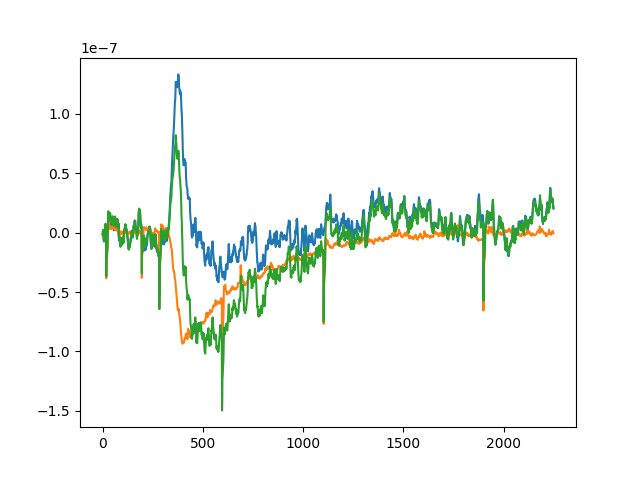

In [51]:
plt.figure()
plt.plot(mean_layer_disconnected[0,5,:])
plt.plot(mean_layer_disconnected[0,6,:])
plt.plot(np.sum(mean_layer_disconnected[0,5:,:],axis=0))

In [12]:
mean_layer_disconnected, lowerbound_layer_disconnected, upperbound_layer_disconnected = getByLayer(s3)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [13]:
mean_layer_original, lowerbound_layer_original, upperbound_layer_original= getByLayer(s1)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [14]:
mean_layer_rewired, lowerbound_layer_rewired, upperbound_layer_rewired= getByLayer(s2)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [15]:
mean_layer_rewiredD, lowerbound_layer_rewiredD, upperbound_layer_rewiredD = getByLayer(s6)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [16]:
mean_layer_rewiredDS, lowerbound_layer_rewiredDS, upperbound_layer_rewiredDS = getByLayer(s7)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [17]:
mean_layer_L5, lowerbound_layer_L5, upperbound_layer_L5 = getByLayer(s5)
mean_layer_L23, lowerbound_layer_L23, upperbound_layer_L23 = getByLayer(s4)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [121]:
mean_spikes,lowerbound_spikes,upperbound_spikes = meanAndCI(spikes_original)
mean_spikes_disconnected,lowerbound_spikes_disconnected,upperbound_spikes_disconnected = meanAndCI(spikes_disconnected)

In [17]:
time = np.linspace(0,225,2250)

In [18]:
def getTimeIndices(bins,startTime=0,endTime=225):

    '''
    Given a vector of bins from a spike histogram, finds the time steps corresponding to each bin in an EEG trace sampled at 10 kHz 
    '''

    time = np.arange(startTime,endTime,.1)

    timeIndices = []
    for t in bins:
        index = np.argmin(np.abs(t-time))
        timeIndices.append(index)

    return timeIndices

In [19]:
def getCorrelationsByLayer(EEGs, spikes,bins=np.arange(225),startTime=0,endTime=225):

    '''
    Given an EEG contribution from each layer, sampled at 10kHz, and a spiking histogram from each layer,
    returns the correlation matrix between the EEG contributions and the spike frequencies
    '''

    timeIndices = getTimeIndices(bins,startTime,endTime)

    correlationMatrix = np.zeros([5,5])
    
    for i in range(5):
    
        for j in range(5):
        
            correlationMatrix[i,j] = scipy.stats.pearsonr(spikes[i],EEGs[j][timeIndices]).statistic

    return correlationMatrix

In [77]:
eegDifference = np.sum(mean_layer,axis=0)-np.sum(mean_layer_disconnected,axis=0) # Difference in the EEG contributions per layer between the connected and the disconnected circuit 


In [122]:
allSpikes = mean_spikes.sum(axis=0) # Sums spike histograms for excitatory and inhibitory cells to produce one for all cells
# Sums 95% CI  for both histograms
lowerbound_spikes = lowerbound_spikes.sum(axis=0) 
upperbound_spikes=upperbound_spikes.sum(axis=0)


In [123]:
# Does the same as in the cell above, but for the disconnected circuit

allSpikes_disconnected = mean_spikes_disconnected.sum(axis=0)
lowerbound_spikes_disconnected = lowerbound_spikes_disconnected.sum(axis=0)
upperbound_spikes_disconnected=upperbound_spikes_disconnected.sum(axis=0)


In [85]:
# Finds correlations between EEG and firing rate, for the overall signal and for specified time windows

(2, 7, 2250)

In [107]:
correlationsExcExc = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[0])
correlationsExcExcP = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=35,endTime=45)
correlationsExcExcN = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=45,endTime=60)

correlationsExcExcDiff = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[0])
correlationsExcExcDiffP = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=35,endTime=45)
correlationsExcExcDiffN = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=45,endTime=60)
correlationsExcExcDiffL = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=60,endTime=200)


In [106]:
correlationsInhExc = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[1])
correlationsInhExcP = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=35,endTime=45)
correlationsInhExcN = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=45,endTime=60)

correlationsInhExcDiff = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[1])
correlationsInhExcDiffP = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=35,endTime=45)
correlationsInhExcDiffN = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=45,endTime=60)
correlationsInhExcDiffL = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=60,endTime=200)


/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [133]:
plotTime = np.linspace(-25,200,2250) # Time vector with the stimulus occurring at 0 ms

### Produces Panel b of Figure 6 in the BlueRecording paper

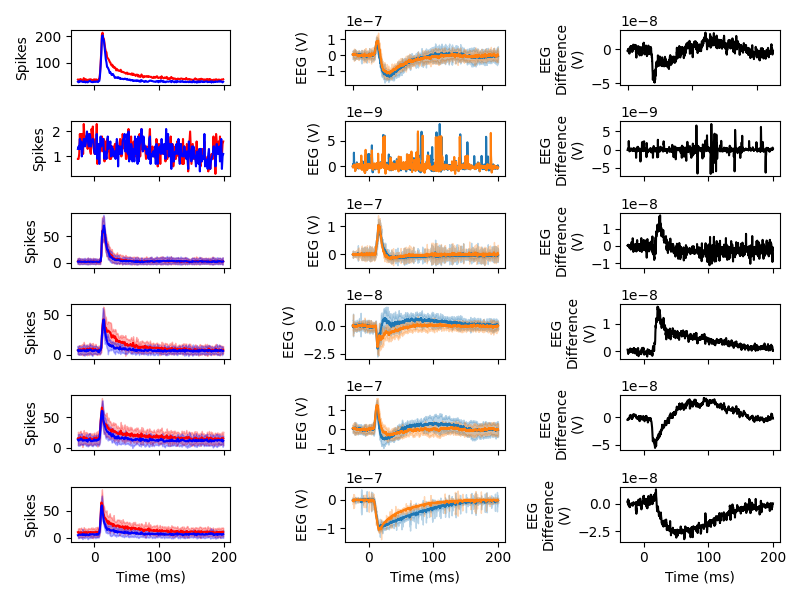

In [172]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,6))

gs = GridSpec(6,3, figure=fig)

ax = fig.add_subplot(gs[0,0])

ax.plot(np.arange(-25,200),np.sum(allSpikes,axis=0),c='r')
ax.plot(np.arange(-25,200),np.sum(allSpikes_disconnected,axis=0),c='b')
ax.fill_between(np.arange(-25,200),np.sum(lowerbound_spikes,axis=0),np.sum(upperbound_spikes,axis=0),color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),np.sum(lowerbound_spikes_disconnected,axis=0),np.sum(upperbound_spikes_disconnected,axis=0),color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])

ax = fig.add_subplot(gs[0,1])
                     
ax.plot(time,meanEEG)
ax.plot(time,meanEEG_disconnected)
ax.fill_between(time,lowerboundEEG,upperboundEEG,color='C0',alpha=0.3)
ax.fill_between(time,lowerboundEEG_disconnected,upperboundEEG_disconnected,color='C1',alpha=0.3)
ax.set_ylabel('EEG (V)')
ax.set_xticklabels([])

ax = fig.add_subplot(gs[0,2])
                     
ax.plot(time,meanEEG-meanEEG_disconnected,c='k')
ax.set_ylabel('EEG\nDifference\n(V)')
ax.set_xticklabels([])

    
ax = fig.add_subplot(gs[1,0])

ax.plot(np.arange(-25,200),allSpikes[0],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[0],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[0],upperbound_spikes[0],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[0],upperbound_spikes_disconnected[0],color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])


ax = fig.add_subplot(gs[2,0])

ax.plot(np.arange(-25,200),allSpikes[1]+allSpikes[2],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[1]+allSpikes_disconnected[2],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[1]+lowerbound_spikes[2],upperbound_spikes[1]+upperbound_spikes[2],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[1]+lowerbound_spikes_disconnected[2],upperbound_spikes_disconnected[1]+upperbound_spikes_disconnected[2],color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])


ax = fig.add_subplot(gs[3,0])

ax.plot(np.arange(-25,200),allSpikes[3],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[3],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[3],upperbound_spikes[3],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[3],upperbound_spikes_disconnected[3],color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])


ax = fig.add_subplot(gs[4,0])

ax.plot(np.arange(-25,200),allSpikes[4],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[4],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[4],upperbound_spikes[4],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[4],upperbound_spikes_disconnected[4],color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])

ax = fig.add_subplot(gs[5,0])

ax.plot(np.arange(-25,200),allSpikes[5],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[5],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[5],upperbound_spikes[5],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[5],upperbound_spikes_disconnected[5],color='b',alpha=0.3)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Spikes')

ax0 = fig.add_subplot(gs[1,1])
ax1 = fig.add_subplot(gs[2,1])
ax2 = fig.add_subplot(gs[3,1])
ax3 = fig.add_subplot(gs[4,1])
ax4 = fig.add_subplot(gs[5,1])

axes = [ax0,ax1,ax2,ax3,ax4]


for i, layer in enumerate([1,2,4,5,6]):

    
    ax = axes[i]
    ax.plot(plotTime,np.sum(mean_layer[:,layer],axis=0))  
    ax.plot(plotTime,np.sum(mean_layer_disconnected[:,layer],axis=0))  
    ax.fill_between(plotTime,np.sum(lowerbound_layer[:,layer],axis=0),np.sum(upperbound_layer[:,layer],axis=0),color='C0',alpha=0.3)
    ax.fill_between(plotTime,np.sum(lowerbound_layer_disconnected[:,layer],axis=0),np.sum(upperbound_layer_disconnected[:,layer],axis=0),color='C1',alpha=0.3)

    if layer == 6:
        ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticklabels([])
    ax.set_ylabel('EEG (V)')

ax0 = fig.add_subplot(gs[1,2])
ax1 = fig.add_subplot(gs[2,2])
ax2 = fig.add_subplot(gs[3,2])
ax3 = fig.add_subplot(gs[4,2])
ax4 = fig.add_subplot(gs[5,2])

axes = [ax0,ax1,ax2,ax3,ax4]


for i, layer in enumerate([1,2,4,5,6]):

    
    ax = axes[i]
    ax.plot(plotTime,np.sum(mean_layer[:,layer],axis=0)-np.sum(mean_layer_disconnected[:,layer],axis=0),c='k') 
    if layer == 6:
        ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticklabels([])
    ax.set_ylabel('EEG\nDifference\n(V)')


plt.tight_layout()
# plt.show()
plt.savefig('figures/whiskerflick_eeg.png',dpi=300)

### Produces Panel c of Figure 6 in the BlueRecording paper

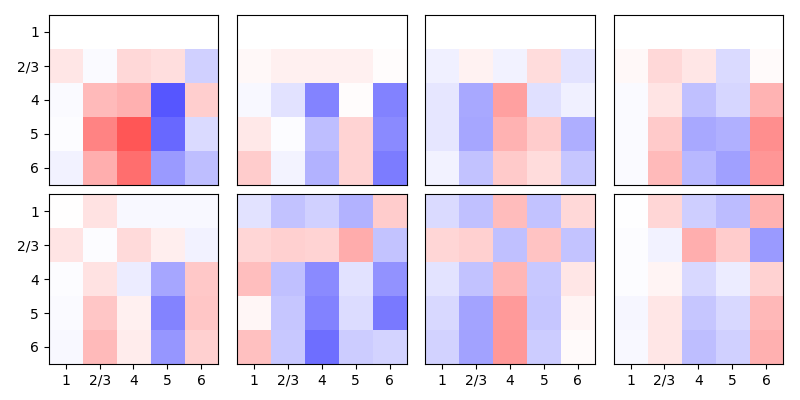

In [173]:
fig = plt.figure(figsize=(8,4))

gs = GridSpec(2,4, figure=fig)

ax = fig.add_subplot(gs[0,0])
ax.imshow(correlationsExcExcDiff,cmap='bwr',vmin=-1,vmax=1)
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xticks([])

ax = fig.add_subplot(gs[0,1])
ax.imshow(correlationsExcExc)
ax.imshow(correlationsExcExcDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.yticks([])
plt.xticks([])

ax = fig.add_subplot(gs[0,2])
ax.imshow(correlationsExcExc)
ax.imshow(correlationsExcExcDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks([])
plt.yticks([])


ax = fig.add_subplot(gs[0,3])
ax.imshow(correlationsExcExcDiffL,cmap='bwr',vmin=-1,vmax=1)
plt.yticks([])
plt.xticks([])


plt.yticks([])
plt.xticks([])

plt.yticks([])
plt.xticks([])

ax = fig.add_subplot(gs[1,0])
ax.imshow(correlationsInhExcDiff,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])

ax = fig.add_subplot(gs[1,1])
ax.imshow(correlationsInhExcDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks([])

ax = fig.add_subplot(gs[1,2])
ax.imshow(correlationsInhExcDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks([])

ax = fig.add_subplot(gs[1,3])
ax.imshow(correlationsInhExcDiffL,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks([])

plt.tight_layout()
plt.savefig('figures/whiskerflick_correlations.png',dpi=300)